### Creating the environment

In [1]:
import tensorflow as tf
import numpy as np
import retro #Retro environment

from skimage import transform #Preprocess the frames
from skimage.color import rgb2gray #To gray the frames

import matplotlib.pyplot as plt #Display graphs

from collections import deque #Ordered collections with ends

import random

import warnings #To ignore all warning messages printed during training
warnings.filterwarnings('ignore')

In [3]:
env = retro.make(game='PunchOut-Nes', state='levelFinal-PunchOut.state')

print("Size of frame:", env.observation_space)
print("Actions size:", env.action_space.n)

#Create a hot encoded version of our actions
#possible_actions = [[1,0,0,0,0,0,0,0], [0,1,0,0,0,0,0,0], ...]
actions = []
actions.append([1,0,0,0,1,0,0,0,0]) #left up punch
actions.append([0,0,0,0,0,0,0,0,1]) #rigth punch
actions.append([0,0,0,0,0,0,0,1,0]) #move left
#actions.append([0,0,0,0,0,1,0,0,0]) #cover
actions.append([0,0,0,0,0,0,0,0,0]) #nothing

possible_actions = np.array(actions, dtype=int)

print(possible_actions)

Size of frame: Box(224, 240, 3)
Actions size: 9
[[1 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0]]


## Preprocess frames


Previous size:  256 240


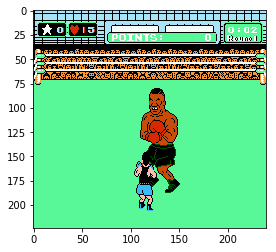

In [4]:
import matplotlib.pyplot as plt

def preprocess_frame(frame):
  gray = rgb2gray(frame)
  
  #Crop the screen  [Up: Down, Left: Rigth]
  cropped_frame = gray[95:185, 80:160]

  #Normalize
  normalized_frame = cropped_frame/255.0
  
  #Resize
  prepropcessed_frame = transform.resize(normalized_frame, [int(90/1.2),int(80/1.2)])
  
  return prepropcessed_frame #158x88x1

#256x240 to 158x88

st1 = env.reset()
plt.imshow(st1)
print("Previous size: ", 256,240)

New size:  75 66


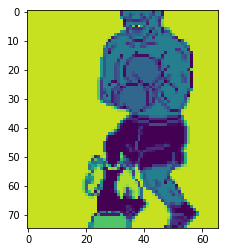

In [5]:
st2 = preprocess_frame(st1)
print("New size: ", int(90/1.2),int(80/1.2))
plt.imshow(st2)

## Stack the frames

In [6]:
stack_size = 8 # We stack 4 frames

# Initialize deque with zero-images one array for each image
stacked_frames  =  deque([np.zeros((75,66), dtype=np.int) for i in range(stack_size)], maxlen=8)

def stack_frames(stacked_frames, state, is_new_episode):
    # Preprocess frame
    frame = preprocess_frame(state)
    
    if is_new_episode:
        # Clear our stacked_frames
        stacked_frames = deque([np.zeros((75,66), dtype=np.int) for i in range(stack_size)], maxlen=8)
        
        # Because we're in a new episode, copy the same frame 4x
        for i in range(8):
            stacked_frames.append(frame)
        
        # Stack the frames
        stacked_state = np.stack(stacked_frames, axis=2)
        
    else:
        # Append frame to deque, automatically removes the oldest frame
        stacked_frames.append(frame)

        # Build the stacked state (first dimension specifies different frames)
        stacked_state = np.stack(stacked_frames, axis=2) 
    
    return stacked_state, stacked_frames

## Hiperparameters

In [17]:
### MODEL HYPERPARAMETERS
state_size = [75, 66, 8]      # Our input is a stack of 4 frames hence 110x84x4 (Width, height, channels) 
action_size = env.action_space.n # 3 possible actions
learning_rate =  0.00025      # Alpha (aka learning rate)

### TRAINING HYPERPARAMETERS
total_episodes = 300            # Total episodes for training
max_steps = 10000               # Max possible steps in an episode
batch_size = 64                # Batch size

# Exploration parameters for epsilon greedy strategy
explore_start = 1.0            # exploration probability at start
explore_stop = 0.10            # minimum exploration probability 
decay_rate = 0.000016          # exponential decay rate for exploration prob

# Q learning hyperparameters
gamma = 0.9                    # Discounting rate

### MEMORY HYPERPARAMETERS
pretrain_length = batch_size   # Number of experiences stored in the Memory when initialized for the first time
memory_size = 1000000          # Number of experiences the Memory can keep

### PREPROCESSING HYPERPARAMETERS
stack_size = 8                 # Number of frames stacked

### MODIFY THIS TO FALSE IF YOU JUST WANT TO SEE THE TRAINED AGENT
training = True

## TURN THIS TO TRUE IF YOU WANT TO RENDER THE ENVIRONMENT
episode_render = False

### Create Deep Q-Learning Neural Network Model



*   Stack de 4 frames como input
*   Se pasa por 3 convnets
*   Luego se flatened 
*   Finalmente se pasa por 2 FC layers (Fully connected layers)
*   Output o sale el Q value de cada accion





In [8]:
class DQNetwork():
  def __init__(self, state_size, action_size, learning_rate, name='DQNetwork'):
    self.state_size = state_size
    self.action_size = action_size
    self.learning_rate = learning_rate
    
    with tf.variable_scope(name):
      #placeholders
      #*state_size means that we take each element of the state_size in tuple hence is like if we wrote
      #[None, 84, 84, 4]
      
      self.inputs_ = tf.placeholder(tf.float32, [None, *state_size], name="inputs")
      self.actions_ = tf.placeholder(tf.float32, [None, self.action_size], name="actions_")
      
      #target_q is the R(s,a) + ymax Qhat(s',a') : estimated Q value
      self.target_Q = tf.placeholder(tf.float32, [None], name="target")
      
      #First convnet:
      #CNN
      #ELU
      
      #Input is 110x84x4
      self.conv1 = tf.layers.conv2d(inputs = self.inputs_,
                                   filters = 32,
                                   kernel_size = [8,8],
                                   strides = [4,4],
                                   padding = 'VALID',
                                   kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d(),
                                   name = 'conv1'
                                   )
      
      self.conv1_out = tf.nn.elu(self.conv1, name='conv1_out')
      
      #Second convnet:
      #CNN
      #ELU
      
      self.conv2 = tf.layers.conv2d(inputs = self.conv1_out,
                                   filters = 64,
                                   kernel_size = [4,4],
                                   strides = [2,2],
                                   padding = 'VALID',
                                   kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d(),
                                   name = 'conv2'
                                   )
      
      self.conv2_out = tf.nn.elu(self.conv2, name='conv2_out')
      
      #Third convnet:
      #CNN
      #ELU
      
      self.conv3 = tf.layers.conv2d(inputs = self.conv2_out,
                                   filters = 64,
                                   kernel_size = [3,3],
                                   strides = [2,2],
                                   padding = 'VALID',
                                   kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d(),
                                   name = 'conv3'
                                   )
      
      self.conv3_out = tf.nn.elu(self.conv3, name='conv3_out')
      
      #Flatten
      self.flatten = tf.contrib.layers.flatten(self.conv3_out)
      
      self.fc = tf.layers.dense(inputs = self.flatten,
                                units = 512,
                                activation = tf.nn.elu,
                                kernel_initializer = tf.contrib.layers.xavier_initializer(),
                                name = 'fc1'
                                )
      
      #Output the Q value for each action
      self.output = tf.layers.dense(inputs = self.fc,
                                   kernel_initializer = tf.contrib.layers.xavier_initializer(),
                                  units = self.action_size,
                                  activation = None
                                  )
      
      #Q is our predicted value
      self.Q = tf.reduce_sum(tf.multiply(self.output, self.actions_))
      print('output: ', self.output)
      print('actions_: ', self.actions_)
      
      #The loss is the difference between our predicted Q_values and the Q_target
      #Sum(Q_target - Q)^2
      self.loss = tf.reduce_mean(tf.square(self.target_Q - self.Q))
      
      
      #Optimize using AdamOptimizer tho minimize the loss 
      #For training the Network
      self.optimizer = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
  

In [9]:
#Reset the graph
tf.reset_default_graph()

#Instantiate the DQNetwork
DQNetwork = DQNetwork(state_size, action_size, learning_rate)

output:  Tensor("DQNetwork/dense/BiasAdd:0", shape=(?, 9), dtype=float32)
actions_:  Tensor("DQNetwork/actions_:0", shape=(?, 9), dtype=float32)


### Experience Replay

Implement the Experience replay method
We create the Memory object that creates a deque.A deque (double ended queue) **is a data type that removes the oldest element each time that a new one is added** . \n
Code from Udacity

In [10]:
class Memory():
    def __init__(self, max_size):
        self.buffer = deque(maxlen = max_size)
   
    #add new experience to the deque
    def add(self, experience):
        self.buffer.append(experience)
    
    #Create a batch of randomize experience
    def sample(self, batch_size):
        buffer_size = len(self.buffer)
        index = np.random.choice(np.arange(buffer_size),
                                size = batch_size,
                                replace = False)
        
        return [self.buffer[i] for i in index]
    

Here we will **deal with empty memory problem**: we pre-populate the memory by taking random actions and storing the experience (state, action, reward, nex_state)

In [11]:
# Instantiate memory
memory = Memory(max_size = memory_size)
for i in range(pretrain_length):
    # If it's the first step
    if i == 0:
        state = env.reset()
        
        state, stacked_frames = stack_frames(stacked_frames, state, True)
        
    # Get the next_state, the rewards, done by taking a random action
    if i%6==0:
        choice = random.randint(1,len(possible_actions))-1
    action = possible_actions[choice]
    
    next_state, reward, done, _ = env.step(action)
    
    #env.render()
    
    # Stack the frames
    next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
    
    
    # If the episode is finished (we're dead 3x)
    if done:
        # We finished the episode
        next_state = np.zeros(state.shape)
        
        # Add experience to memory
        memory.add((state, action, reward, next_state, done))
        
        # Start a new episode
        state = env.reset()
        
        # Stack the frames
        state, stacked_frames = stack_frames(stacked_frames, state, True)
        
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state, done))
        
        # Our new state is now the next_state
        state = next_state

### Tensorboard
To launch tensorboard: tensorboard --logdir=/tensorboard/dqn/1

In [12]:
# Setup TensorBoard Writer
writer = tf.summary.FileWriter("./tensorboard/dqn/lvlF/2")

## Losses
tf.summary.scalar("Loss", DQNetwork.loss)

write_op = tf.summary.merge_all()

In [13]:
! --logdir="/tensorboard/dqn/1"

/bin/sh: 1: --logdir=/tensorboard/dqn/1: not found


### Train the agent

Algorithm:

- Initialize weigths
- Init the environment
- Initialize the decay rate (epsilon greedy)


> **For episode to max_episode do:**
- Make new episode
- Set step to 0
- Observe the first state $s_0$

>> **While step < max_steps do:**
- Increase decay_rate
- With $e$ select a random action $a_t$, otherwise select $a_t = argmax_a Q(s_t,a)$
- Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s{t+1}$
- Store transition $ @ $
- Sample random mini-batch from $D:@ $
- Set $ Q' = r $ if the episode ends alt $+1$, otherwise set $Q' = r + ymax_a Q(s',a') $
- Make a gradient descent step with loss $(Q'-Q(s,a))^2$

>> **endfor**

> **endfor**








  



In [14]:
#Function that predicts the action to take, random or argmax_aQ(s',a')

def predict_action(explore_start, explore_stop, decay_rate, decay_step, state, actions):
    ## EPSILON GREEDY
    # Choose action a from state s using epsilon greedy.
    ## First we randomize a number
    exp_exp_tradeoff = np.random.rand()

    # Here we'll use an improved version of our epsilon greedy strategy used in Q-learning notebook
    explore_probability = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * decay_step)
    
    if (explore_probability > exp_exp_tradeoff):
        # Make a random action (exploration)
        choice = random.randint(1,len(possible_actions))-1
        action = possible_actions[choice]
        
    else:
        # Get action from Q-network (exploitation)
        # Estimate the Qs values state
        Qs = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state.reshape((1, *state.shape))})
        
        # Take the biggest Q value (= the best action)
        choice = np.argmax(Qs)%4
        action = possible_actions[choice]
                
                
    return action, explore_probability

In [ ]:
# from google.colab import files

# Saver will help us to save our model
saver = tf.train.Saver()

if training == True:
  with tf.Session() as sess:
      # Initialize the variables
      sess.run(tf.global_variables_initializer())

      # Initialize the decay rate (that will use to reduce epsilon) 
      decay_step = 0
      rewards_list = []

      for episode in range(total_episodes):
          # Set step to 0
          step = 0

          # Initialize the rewards of the episode
          episode_rewards = []

          # Make a new episode and observe the first state
          state = env.reset()

          # Remember that stack frame function also call our preprocess function.
          state, stacked_frames = stack_frames(stacked_frames, state, True)

          while step < max_steps:
              step += 1
              
              if step%400==0:
                    print(step)

              #Increase decay_step
              decay_step +=1
                
              if step%6==0:
                # Predict the action to take and take it every 6 frames
                action, explore_probability = predict_action(explore_start, explore_stop, decay_rate, decay_step, state, possible_actions)

              #Perform the action and get the next_state, reward, and done information
              next_state, reward, done, _ = env.step(action)
            
              if episode_render:
                  env.render()

              # Add the reward to total reward
              episode_rewards.append(reward)

              # If the game is finished
              if done:
                  # The episode ends so no next state
                  next_state = np.zeros((256,240), dtype=np.int)

                  next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)

                  # Set step = max_steps to end the episode
                  step = max_steps

                  # Get the total reward of the episode
                  total_reward = np.sum(episode_rewards)

                  print('Episode: {}'.format(episode),
                                'Total reward: {}'.format(total_reward),
                                'Explore P: {:.4f}'.format(explore_probability),
                              'Training Loss {:.4f}'.format(loss))

                  rewards_list.append((episode, total_reward))

                  # Store transition <st,at,rt+1,st+1> in memory D
                  memory.add((state, action, reward, next_state, done))

              else:
                  # Stack the frame of the next_state
                  next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)

                  # Add experience to memory
                  memory.add((state, action, reward, next_state, done))

                  # st+1 is now our current state
                  state = next_state


              ### LEARNING PART            
              # Obtain random mini-batch from memory
              batch = memory.sample(batch_size)
              states_mb = np.array([each[0] for each in batch], ndmin=3)

              actions_mb = np.array([each[1] for each in batch])
              rewards_mb = np.array([each[2] for each in batch]) 
              next_states_mb = np.array([each[3] for each in batch], ndmin=3)
              dones_mb = np.array([each[4] for each in batch])

              target_Qs_batch = []

              # Get Q values for next_state 
              Qs_next_state = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: next_states_mb})

              # Set Q_target = r if the episode ends at s+1, otherwise set Q_target = r + gamma*maxQ(s', a')
              for i in range(0, len(batch)):
                  terminal = dones_mb[i]

                  # If we are in a terminal state, only equals reward
                  if terminal:
                      target_Qs_batch.append(rewards_mb[i])

                  else:
                      target = rewards_mb[i] + gamma * np.max(Qs_next_state[i])
                      target_Qs_batch.append(target)


              targets_mb = np.array([each for each in target_Qs_batch])

              loss, _ = sess.run([DQNetwork.loss, DQNetwork.optimizer],
                                      feed_dict={DQNetwork.inputs_: states_mb,
                                                 DQNetwork.target_Q: targets_mb,
                                                 DQNetwork.actions_: actions_mb})

              # Write TF Summaries
              summary = sess.run(write_op, feed_dict={DQNetwork.inputs_: states_mb,
                                                     DQNetwork.target_Q: targets_mb,
                                                     DQNetwork.actions_: actions_mb})
              writer.add_summary(summary, episode)
              writer.flush()

          # Save model every 5 episodes
          if episode % 2 == 0:
              save_path = saver.save(sess, "./models/lvl3/1/modelTyson.ckpt")
              #files.download("./models/model.ckpt")
              print("Model Saved")
        
          

400
800
Episode: 0 Total reward: -356.8000121116638 Explore P: 0.9840 Training Loss 0.0136
Model Saved
400
800
Episode: 1 Total reward: -356.8000121116638 Explore P: 0.9682 Training Loss 0.0109
400
800
1200
Episode: 2 Total reward: -364.8000121116638 Explore P: 0.9504 Training Loss 0.0090
Model Saved
400
800
1200
1600
Episode: 3 Total reward: -582.5000159144402 Explore P: 0.9269 Training Loss 0.0121
400
800
1200
1600
Episode: 4 Total reward: -347.8000121116638 Explore P: 0.9060 Training Loss 0.0781
Model Saved
400
800
Episode: 5 Total reward: -359.10001212358475 Explore P: 0.8912 Training Loss 0.0171
400
800
1200
1600
Episode: 6 Total reward: -643.6000185012817 Explore P: 0.8666 Training Loss 0.0160
Model Saved
400
800
Episode: 7 Total reward: -358.6000121831894 Explore P: 0.8529 Training Loss 0.0142
400
800
1200
1600
Episode: 8 Total reward: -599.500016272068 Explore P: 0.8305 Training Loss 0.0157
Model Saved
400
800
Episode: 9 Total reward: -360.9000121951103 Explore P: 0.8171 Traini

400
800
Episode: 81 Total reward: -360.9000121951103 Explore P: 0.2579 Training Loss 0.0613
400
800
Episode: 82 Total reward: -352.4000120162964 Explore P: 0.2550 Training Loss 0.0120
Model Saved
400
800
Episode: 83 Total reward: -354.5000120997429 Explore P: 0.2523 Training Loss 0.0201
400
800
Episode: 84 Total reward: -358.6000121831894 Explore P: 0.2496 Training Loss 0.0332
Model Saved
400
800
Episode: 85 Total reward: -360.20001208782196 Explore P: 0.2468 Training Loss 0.0148
400
800
Episode: 86 Total reward: -354.5000120997429 Explore P: 0.2442 Training Loss 0.0310
Model Saved
400
800
1200
Episode: 87 Total reward: -360.5000120997429 Explore P: 0.2414 Training Loss 0.0200
400
800
Episode: 88 Total reward: -357.90001207590103 Explore P: 0.2388 Training Loss 0.0233
Model Saved
400
800
1200
Episode: 89 Total reward: -345.10001212358475 Explore P: 0.2357 Training Loss 0.0186
400
800
1200
Episode: 90 Total reward: -362.5000120997429 Explore P: 0.2330 Training Loss 0.0149
Model Saved
40

### Test and watch the agent

In [14]:
#For replay the game
#env = retro.make(game='PunchOut-Nes', state='level2-PunchOut.state')
saver = tf.train.Saver()

with tf.Session() as sess:
    total_test_rewards = []
    
    # Load the model
    saver.restore(sess, "./models/lvl2/6/model.ckpt")
    
    for episode in range(1):
        total_rewards = 0
        
        state = env.reset()
        state, stacked_frames = stack_frames(stacked_frames, state, True)
        
        print("****************************************************")
        print("EPISODE ", episode)
        step = 0
        while step < 99999:
            step += 1
            # Reshape the state
            state = state.reshape((1, *state_size))
            # Get action from Q-network 
            # Estimate the Qs values state
            Qs = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state})
            
            if step%6==0:
            # Take the biggest Q value (= the best action)
                choice = np.argmax(Qs)%4
            action = possible_actions[choice]
            
            print(action, reward)
            
            #Perform the action and get the next_state, reward, and done information
            next_state, reward, done, _ = env.step(action)
            
            if tuple(action) == tuple(possible_actions[3]):
                reward += 2
            
            env.render()
            
            total_rewards += reward

            if done:
                print ("Score", total_rewards)
                total_test_rewards.append(total_rewards)
                break
                
                
            next_state, stacked_frames = stack_frames(stacked_frames, next_state, False)
            state = next_state
            
    env.render(close=True)
    env.close()

INFO:tensorflow:Restoring parameters from ./models/lvl2/6/model.ckpt
****************************************************
EPISODE  0
[1 0 0 0 1 0 0 0 0] 0.0
[1 0 0 0 1 0 0 0 0] 0.0
[1 0 0 0 1 0 0 0 0] 0.0
[1 0 0 0 1 0 0 0 0] 0.0
[1 0 0 0 1 0 0 0 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 0 0] 0.0
[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 0 1] 2.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 

[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] -9.0
[0 0 0 0 0 0 0 1 0] -2.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 0 0] 0.0
[0 0 0 0 0 0 0

[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[1 0 0 0 1 0 0 0 0] 0.0
[1 0 0 0 1 0 0 0 0] 0.0
[1 0 0 0 1 0 0 0 0] 0.0
[1 0 0 0 1 0 0 0 0] 0.0
[1 0 0 0 1 0 0 0 0] 0.0
[1 0 0 0 1 0 0 0 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1

[1 0 0 0 1 0 0 0 0] 0.0
[1 0 0 0 1 0 0 0 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 3.0
[0 0 0 0 0 0 0 1 0] 0.0
[1 0 0 0 1 0 0 0 0] 0.0
[1 0 0 0 1 0 0 0 0] 0.0
[1 0 0 0 1 0 0 0 0] 0.0
[1 0 0 0 1 0 0 0 0] 0.0
[1 0 0 0 1 0 0 0 0] 0.0
[1 0 0 0 1 0 0 0 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[1 0 0 0 1 0 0 0 0] 0.0
[1 0 0 0 1 0 0 0 0] 0.0
[1 0 0 0 1 0 0 0 0] 0.0
[1 0 0 0 1 0 0 0 0] 0.0
[1 0 0 0 1 0 0 0 0] 0.0
[1 0 0 0 1 0 0 0 0] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0

[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[1 0 0 0 1 0 0 0 0] 0.0
[1 0 0 0 1 0 0 0 0] 0.0
[1 0 0 0 1 0 0 0 0] 0.0
[1 0 0 0 1 0 0 0 0] 0.0
[1 0 0 0 1 0 0 0 0] 0.0
[1 0 0 0 1 0 0 0 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0 1] 3.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1

[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0 1] -2.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 

[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0 1] 5.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 0 0] 0.0
[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 0

[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[1 0 0 0 1 0 0 0 0] 0.0
[1 0 0 0 1 0 0 0 0] 0.0
[1 0 0 0 1 0 0 0 0] 0.0
[1 0 0 0 1 0 0 0 0] 0.0
[1 0 0 0 1 0 0 0 0] 0.0
[1 0 0 0 1 0 0 0 0] 0.0
[0 0 0 0 0 0 0 0 0] 0.0
[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 0

[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 0 0] 0.0
[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 1 0] 2.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1

[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 0 0] 0.0
[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 1

[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 1 0] 2.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 0 1] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 0 0] 0.0
[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 0 0] 2.0
[0 0 0 0 0 0 0 0

[0 0 0 0 0 0 0 1 0] 2.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1 0] 0.0
[0 0 0 0 0 0 0 1

In [15]:
env.render(close=True)
env.close()

### Test the actions

In [16]:
env = retro.make(game='PunchOut-Nes', state='level3-PunchOut.state')

with tf.Session() as sess:
    total_test_rewards = []
    
    for episode in range(1):
        total_rewards = 0
        
        state = env.reset()
        
        print("****************************************************")
        print("EPISODE ", episode)
        step = 0
        
        while step<99999:
            
            if step%6==0:
                choice = random.randint(1,len(possible_actions))-1
            action = possible_actions[choice]
            
            
            next_state, reward, done, _info = env.step(action)


            print(reward, action)
            
            env.render()
            
            total_rewards += reward

            if done:
                print ("Score", total_rewards)
                total_test_rewards.append(total_rewards)
                break
                
                
            state = next_state
            step += 1

    env.close()
    env.render(close=True)

    #6 down
    #8 B or A
    #4 B or A

****************************************************
EPISODE  0
0.10000000149011612 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [1 0 0 0 1 0 0 0 0]
-10.0 [1 0 0 0 1 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 1 0]
0.0 [0 0 0 0 0 0 0 1 0]
0.0 [0 0 0 0 0 0 0 1 0]
0.0 [0 0 0 0 0 0 0 1 0]
0.10000000149011612 [0 0 0 0 0 0 0 1 0]
0.10000000149011612 [0 0 0 0 0 0 0 1 0]
0.10000000149011612 [1 0 0 0 1 0 0 0 0]
0.10000000149011612 [1 0 0 0 1 0 0 0 0]
0.10000000149011612 [1 0 0 0 1 0 0 0 0]
0.10000000149011612 [1 0 0 0 1 0 0 0 0]
0.1000

0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 1 0]
0.0 [0 0 0 0 0 0 0 1 0]
0.0 [0 0 0 0 0 0 0 1 0]
0.0 [0 0 0 0 0 0 0 1 0]
0.10000000149011612 [0 0 0 0 0 0 0 1 0]
0.10000000149011612 [0 0 0 0 0 0 0 1 0]
0.10000000149011612 [0 0 0 0 0 0 0 0 1]
0.10000000149011612 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 1]
5.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 1 0]
0.0 [0 0 0 0 0 0 0 1 0]
0.10000000149011612 [0 0 0 0 0 0 0 1 0]
0.10000000149011612 [0 0 0 0 0 0 0 1 0]
0.10000000149011

0.0 [0 0 0 0 0 0 0 1 0]
0.0 [0 0 0 0 0 0 0 1 0]
0.0 [0 0 0 0 0 0 0 1 0]
0.0 [0 0 0 0 0 0 0 1 0]
0.0 [0 0 0 0 0 0 0 1 0]
0.0 [0 0 0 0 0 0 0 1 0]
0.0 [0 0 0 0 0 0 0 1 0]
0.0 [0 0 0 0 0 0 0 1 0]
0.0 [0 0 0 0 0 0 0 1 0]
0.0 [0 0 0 0 0 0 0 1 0]
0.0 [0 0 0 0 0 0 0 1 0]
0.0 [0 0 0 0 0 0 0 1 0]
0.0 [0 0 0 0 0 0 0 1 0]
0.0 [0 0 0 0 0 0 0 1 0]
0.0 [0 0 0 0 0 0 0 1 0]
0.0 [0 0 0 0 0 0 0 1 0]
0.0 [0 0 0 0 0 0 0 1 0]
0.0 [0 0 0 0 0 0 0 1 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.10000000149011612 [1 0 0 0 1 0 0 0 0]
0.10000000149011612 [1 0 0 0 1 0 0 0 0]
0.10000000149011612 [0 0 0 0 0 0 0 0 1]
0.10000000149011612 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]


0.0 [0 0 0 0 0 0 0 1 0]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.10000000149011612 [0 0 0 0 0 0 0 0 0]
0.10000000149011612 [0 0 0 0 0 0 0 0 0]
0.10000000149011612 [0 0 0 0 0 0 0 0 0]
0.10000000149011612 [0 0 0 0 0 0 0 0 0]
0.10000000149011612 [0 0 0 0 0 0 0 0 0]
0.10000000149011612 [0 0 0 0 0 0 0 0 0]
0.10000000149011612 [1 0 0 0 1 0 0 0 0]
0.10000000149011612 [1 0 0 0 1 0 0 0 0]
0.10000000149011612 [1 0 0 0 1 0 0 0 0]
0.10000000149011612 [1 0 0 0 1 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [0 0 0 0 0 0 0 1 0]
-8.0 [0 0 0 0 0 0 0 1 0]
-10.0 [0 0 0 0 0 0 0 1 0]
0.0 [0 0 0 0 0 0 0 1 0]
0.0 [0 0 0 0 0 0 0 1 0]
0.0 [0 0 0 0 0 0 0 1 0]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 

-0.5 [0 0 0 0 0 0 0 1 0]
-0.5 [0 0 0 0 0 0 0 1 0]
-0.5 [0 0 0 0 0 0 0 1 0]
-0.5 [0 0 0 0 0 0 0 1 0]
-0.5 [1 0 0 0 1 0 0 0 0]
-0.5 [1 0 0 0 1 0 0 0 0]
-0.5 [1 0 0 0 1 0 0 0 0]
-0.5 [1 0 0 0 1 0 0 0 0]
-0.5 [1 0 0 0 1 0 0 0 0]
-0.5 [1 0 0 0 1 0 0 0 0]
-0.5 [0 0 0 0 0 0 0 0 1]
-0.5 [0 0 0 0 0 0 0 0 1]
-0.5 [0 0 0 0 0 0 0 0 1]
-0.5 [0 0 0 0 0 0 0 0 1]
-0.5 [0 0 0 0 0 0 0 0 1]
-0.5 [0 0 0 0 0 0 0 0 1]
-0.5 [0 0 0 0 0 0 0 0 0]
-0.5 [0 0 0 0 0 0 0 0 0]
-0.5 [0 0 0 0 0 0 0 0 0]
-0.5 [0 0 0 0 0 0 0 0 0]
-0.5 [0 0 0 0 0 0 0 0 0]
-0.5 [0 0 0 0 0 0 0 0 0]
-0.5 [0 0 0 0 0 0 0 1 0]
-0.5 [0 0 0 0 0 0 0 1 0]
-0.5 [0 0 0 0 0 0 0 1 0]
-0.5 [0 0 0 0 0 0 0 1 0]
-0.5 [0 0 0 0 0 0 0 1 0]
-0.5 [0 0 0 0 0 0 0 1 0]
-0.5 [0 0 0 0 0 0 0 0 0]
-0.5 [0 0 0 0 0 0 0 0 0]
-0.5 [0 0 0 0 0 0 0 0 0]
-0.5 [0 0 0 0 0 0 0 0 0]
-0.5 [0 0 0 0 0 0 0 0 0]
-0.5 [0 0 0 0 0 0 0 0 0]
-0.5 [1 0 0 0 1 0 0 0 0]
-0.5 [1 0 0 0 1 0 0 0 0]
-0.5 [1 0 0 0 1 0 0 0 0]
-0.5 [1 0 0 0 1 0 0 0 0]
-0.5 [1 0 0 0 1 0 0 0 0]
-0.5 [1 0 0 0 1 0 0 0 0]


0.10000000149011612 [1 0 0 0 1 0 0 0 0]
0.10000000149011612 [1 0 0 0 1 0 0 0 0]
0.10000000149011612 [1 0 0 0 1 0 0 0 0]
0.10000000149011612 [1 0 0 0 1 0 0 0 0]
0.10000000149011612 [1 0 0 0 1 0 0 0 0]
0.10000000149011612 [1 0 0 0 1 0 0 0 0]
0.10000000149011612 [1 0 0 0 1 0 0 0 0]
0.10000000149011612 [1 0 0 0 1 0 0 0 0]
0.10000000149011612 [1 0 0 0 1 0 0 0 0]
0.10000000149011612 [1 0 0 0 1 0 0 0 0]
0.10000000149011612 [1 0 0 0 1 0 0 0 0]
0.10000000149011612 [1 0 0 0 1 0 0 0 0]
0.10000000149011612 [1 0 0 0 1 0 0 0 0]
0.10000000149011612 [1 0 0 0 1 0 0 0 0]
0.10000000149011612 [1 0 0 0 1 0 0 0 0]
0.10000000149011612 [1 0 0 0 1 0 0 0 0]
0.10000000149011612 [1 0 0 0 1 0 0 0 0]
0.10000000149011612 [0 0 0 0 0 0 0 1 0]
0.10000000149011612 [0 0 0 0 0 0 0 1 0]
0.10000000149011612 [0 0 0 0 0 0 0 1 0]
0.10000000149011612 [0 0 0 0 0 0 0 1 0]
0.10000000149011612 [0 0 0 0 0 0 0 1 0]
0.10000000149011612 [0 0 0 0 0 0 0 1 0]
0.10000000149011612 [0 0 0 0 0 0 0 1 0]
0.10000000149011612 [0 0 0 0 0 0 0 1 0]


0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
-10.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.10000000149011612 [1 0 0 0 1 0 0 0 0]
0.10000000149011612 [1 0 0 0 1 0 0 0 0]
0.10000000149011612 [0 0 0 0 0 0 0 0 0]
0.10000000149011612 [0 0 0 0 0 0 0 0 0]
0.10000000149011612 [0 0 0 0 0 0 0 0 0]
0.10000000149011612 [0 0 0 0 0 0 0 0 0]
0.10000000149011612 [0 0 0 0 0 0 0 0 0]
0.10000000149011612 [0 0 0 0 0 0 0 0 0]
0.10000000149011612 [0 0 0 0 0 0 0 1 0]
0.10000000149011612 [0 0 0 0 0 0 0 1 0]
0.10000000149011612 [0 0 0 0 0 0 0 1 0]
0.1000

0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
3.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.10000000149011612 [1 0 0 0 1 0 0 0 0]
0.10000000149011612 [1 0 0 0 1 0 0 0 0]
0.10000000149011612 [1 0 0 0 1 0 0 0 0]
0.10000000149011612 [1 0 0 0 1 0 0 0 0]
0.10000000149011612 [1 0 0 0 1 0 0 0 0]
0.10000000149011612 [0 0 0 0 0 0 0 0 0]
0.10000000149011612 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
40.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 1 0]

0.0 [1 0 0 0 1 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [0 0 0 0 0 0 0 1 0]
0.0 [0 0 0 0 0 0 0 1 0]
0.0 [0 0 0 0 0 0 0 1 0]
0.0 [0 0 0 0 0 0 0 1 0]
0.10000000149011612 [0 0 0 0 0 0 0 1 0]
0.10000000149011612 [0 0 0 0 0 0 0 1 0]
0.10000000149011612 [0 0 0 0 0 0 0 0 1]
0.10000000149011612 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [1 0 0 0 1 0 0 0 0]
5.0 [1 0 0 0 1 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]


0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.0 [1 0 0 0 1 0 0 0 0]
0.10000000149011612 [1 0 0 0 1 0 0 0 0]
0.10000000149011612 [1 0 0 0 1 0 0 0 0]
0.10000000149011612 [0 0 0 0 0 0 0 1 0]
0.10000000149011612 [0 0 0 0 0 0 0 1 0]
0.10000000149011612 [0 0 0 0 0 0 0 1 0]
0.10000000149011612 [0 0 0 0 0 0 0 1 0]
0.10000000149011612 [0 0 0 0 0 0 0 1 0]
0.10000000149011612 [0 0 0 0 0 0 0 1 0]
0.10000000149011612 [0 0 0 0 0 0 0 0 0]
0.10000000149011612 [0 0 0 0 0 0 0 0 0]
0.10000000149011612 [0 0 0 0 0 0 0 0 0]
0.10000000149011612 [0 0 0 0 0 0 0 0 0]
0.10000000149011612 [0 0 0 0 0 0 0 0 0]
0.10000000149011612 [0 0 0 0 0 0 0 0 0]
0.10000000149011612 [0 0 0 0 0 0 0 1 0]
0.10000000149011612 [0 0 0 0 0 0 0 1 0]
0.10000000149011612 [0 0 0 0 0 0 0 1 0]
0.0 [0 0 0 0 0 0 0 1 0]
0.0 [0 0 0 0 0 0 0 1 0]
0.0 [0 0

0.10000000149011612 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
5.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.0 [0 0 0 0 0 0 0 0 1]
0.10000000149011612 [0 0 0 0 0 0 0 0 1]
0.10000000149011612 [0 0 0 0 0 0 0 0 1]
0.10000000149011612 [0 0 0 0 0 0 0 1 0]
0.10000000149011612 [0 0 0 0 0 0 0 1 0]
0.10000000149011612 [0 0 0 0 0 0 0 1 0]
0.10000000149011612 [0 0 0 0 0 0 0 1 0]
0.0 [0 0 0 0 0 0 0 1 0]
0.0 [0 0 0 0 0 0 0 1 0]
0.0 [0 0 0 0 0 0 0 1 0]
0.0 [0 0 0 0 0 0 0 1 0]
0.0 [0 0 0 0 0 0 0 1 0]
0.0 [0 0 0 0 0 0 0 1 0]
0.0 [0 0 0 0 0 0 0 1 0]
0.0 [0 0 0 0 0 0 0 1 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]
0.0 [0 0 0 0 0 0 0 0 0]


-0.5 [0 0 0 0 0 0 0 1 0]
-0.5 [0 0 0 0 0 0 0 1 0]
-0.5 [0 0 0 0 0 0 0 1 0]
-0.5 [0 0 0 0 0 0 0 1 0]
-0.5 [0 0 0 0 0 0 0 0 1]
-0.5 [0 0 0 0 0 0 0 0 1]
-0.5 [0 0 0 0 0 0 0 0 1]
-0.5 [0 0 0 0 0 0 0 0 1]
-0.5 [0 0 0 0 0 0 0 0 1]
-0.5 [0 0 0 0 0 0 0 0 1]
-0.5 [0 0 0 0 0 0 0 1 0]
-0.5 [0 0 0 0 0 0 0 1 0]
-0.5 [0 0 0 0 0 0 0 1 0]
-0.5 [0 0 0 0 0 0 0 1 0]
-0.5 [0 0 0 0 0 0 0 1 0]
-0.5 [0 0 0 0 0 0 0 1 0]
-0.5 [0 0 0 0 0 0 0 0 0]
-0.5 [0 0 0 0 0 0 0 0 0]
-0.5 [0 0 0 0 0 0 0 0 0]
-0.5 [0 0 0 0 0 0 0 0 0]
-0.5 [0 0 0 0 0 0 0 0 0]
-0.5 [0 0 0 0 0 0 0 0 0]
-0.5 [0 0 0 0 0 0 0 0 1]
-0.5 [0 0 0 0 0 0 0 0 1]
-0.5 [0 0 0 0 0 0 0 0 1]
-0.5 [0 0 0 0 0 0 0 0 1]
-0.5 [0 0 0 0 0 0 0 0 1]
-0.5 [0 0 0 0 0 0 0 0 1]
-0.5 [1 0 0 0 1 0 0 0 0]
-0.5 [1 0 0 0 1 0 0 0 0]
-0.5 [1 0 0 0 1 0 0 0 0]
-0.5 [1 0 0 0 1 0 0 0 0]
-0.5 [1 0 0 0 1 0 0 0 0]
-0.5 [1 0 0 0 1 0 0 0 0]
-0.5 [0 0 0 0 0 0 0 1 0]
-0.5 [0 0 0 0 0 0 0 1 0]
-0.5 [0 0 0 0 0 0 0 1 0]
-0.5 [0 0 0 0 0 0 0 1 0]
-0.5 [0 0 0 0 0 0 0 1 0]
-0.5 [0 0 0 0 0 0 0 1 0]
